In [42]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
import itertools

from sklearn import svm as SVM
from funcs import cv_profits_for_models, cv_preds_and_confusion_matrix, CustomModelWithThreshold
from funcs import profit_scorer
from customClassifiers import OutlierRemover

In [43]:
train = pd.read_csv('train.csv' ,delimiter="|")
test = pd.read_csv('test.csv', delimiter="|")


train['scannedLineItemsTotal'] = train['scannedLineItemsPerSecond'] * train['totalScanTimeInSeconds']
train['valuePerLineItem'] = train['grandTotal'] / train['scannedLineItemsTotal']
train['quantityModificationsPerLineItem'] = train['quantityModifications'] / train['scannedLineItemsTotal']
train['lineItemVoids*scansWithoutRegistration'] = train['lineItemVoids'] * train['scansWithoutRegistration']

y = train.pop('fraud')
cols = train.columns


scaler = StandardScaler()
scaler.fit(train)
train = scaler.transform(train)

train = pd.DataFrame(train, columns=cols)
train['fraud']=np.float64(y) 

/home/html/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/html/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  app.launch_new_instance()


Set the trust level threshold we want to look at

In [44]:
trust_level_thrs = 2
train = train[train['trustLevel']<=trust_level]

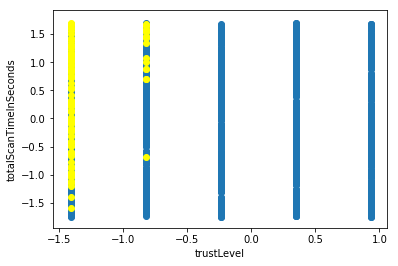

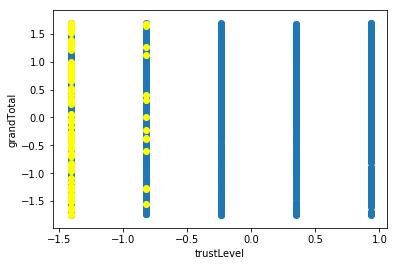

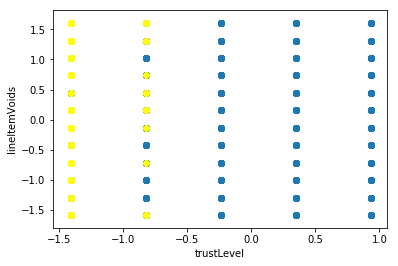

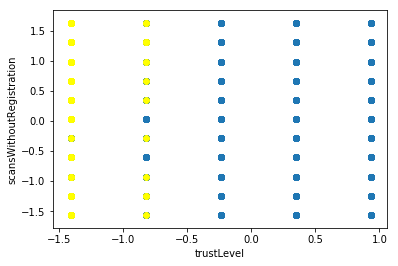

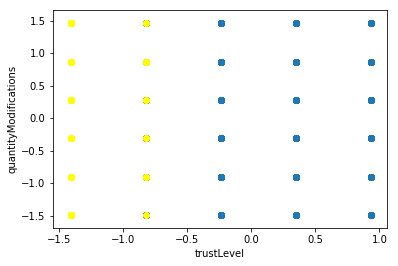

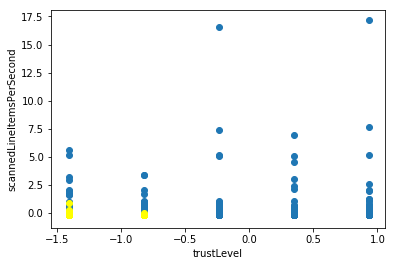

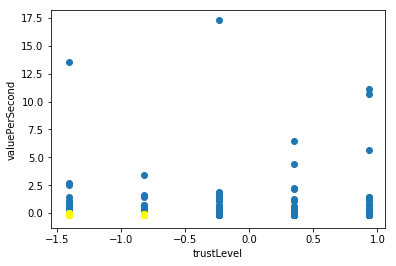

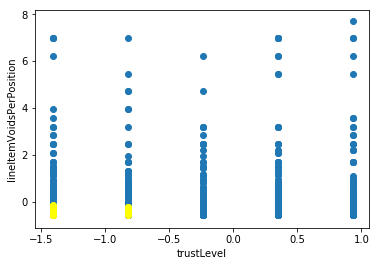

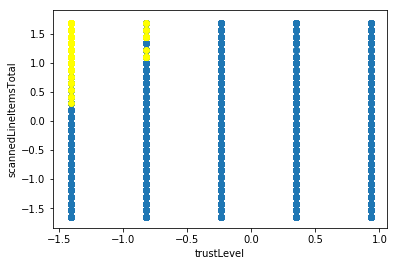

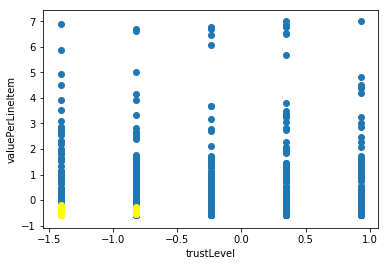

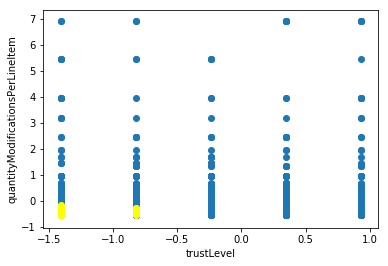

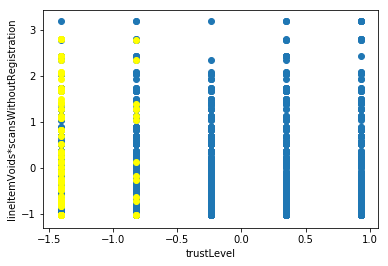

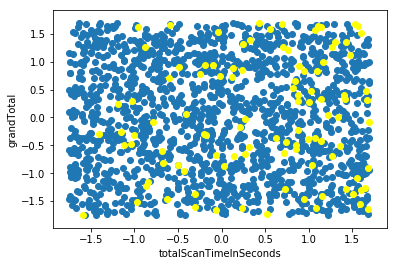

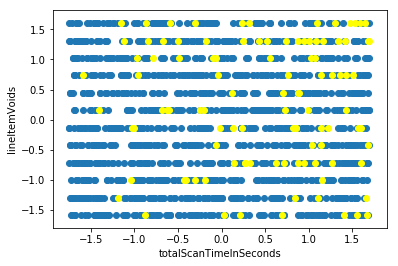

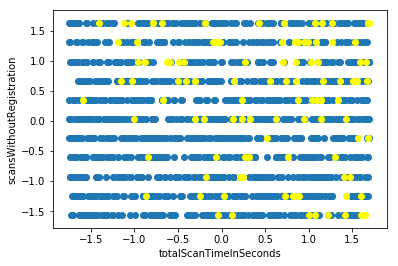

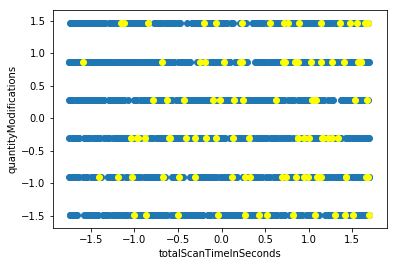

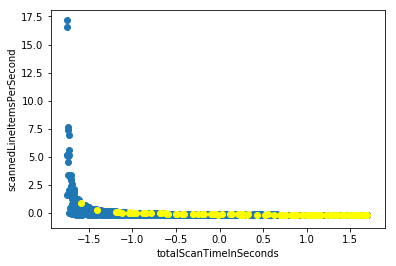

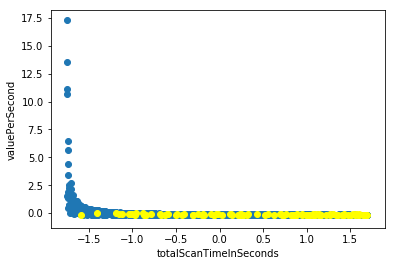

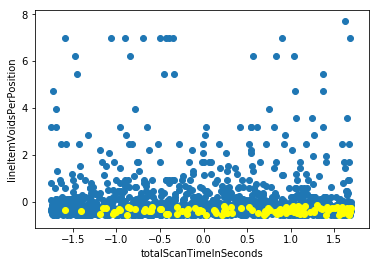

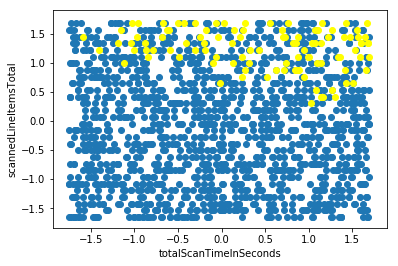

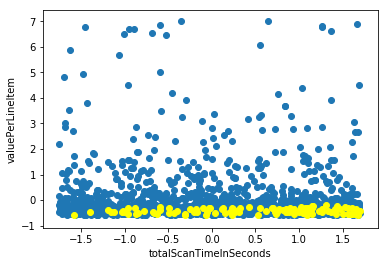

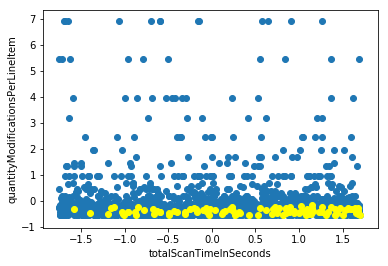

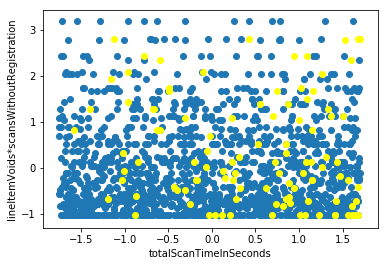

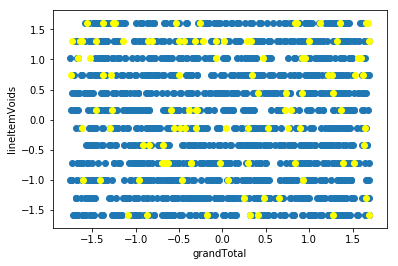

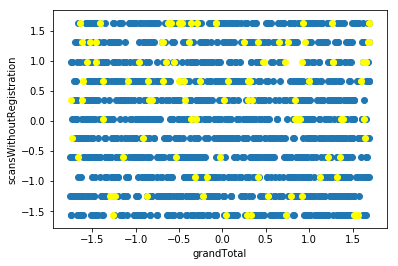

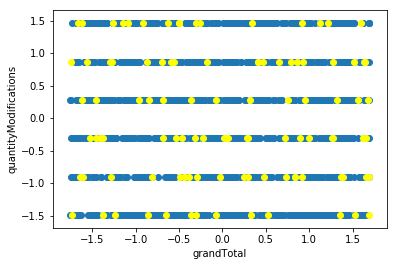

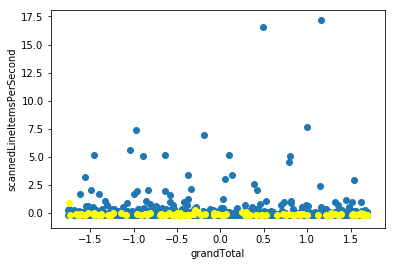

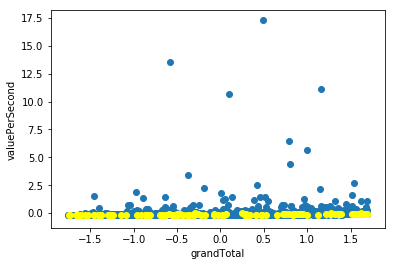

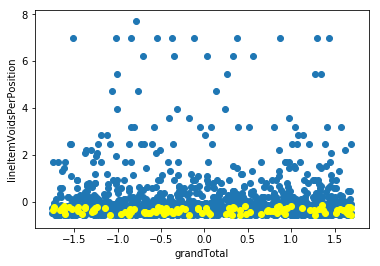

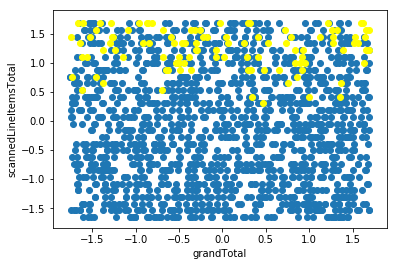

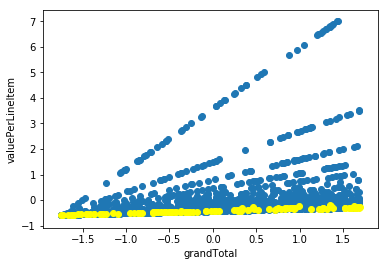

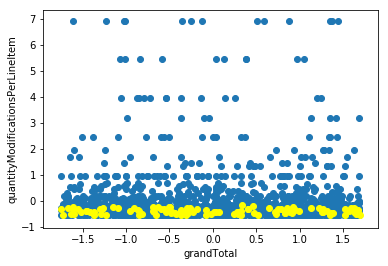

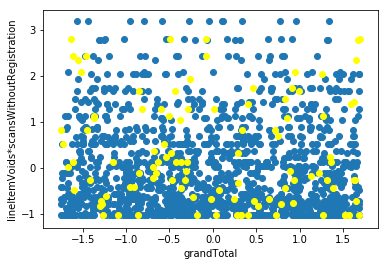

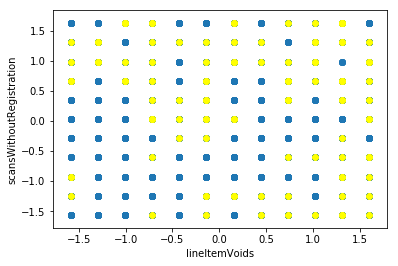

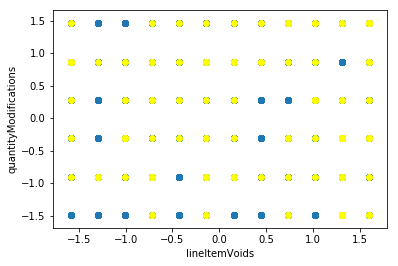

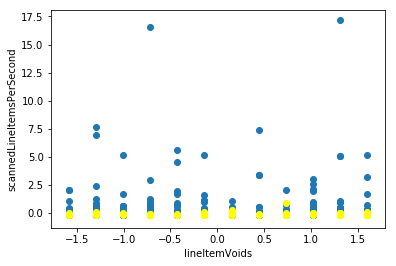

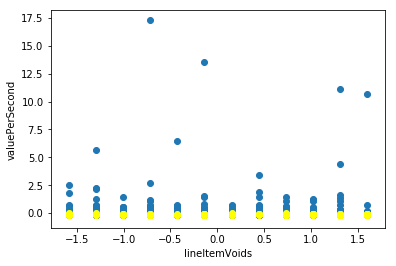

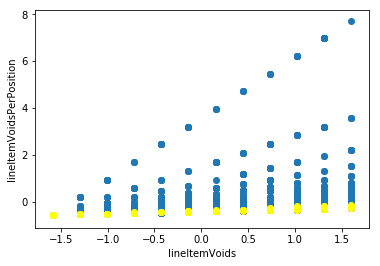

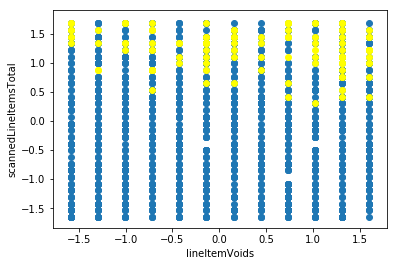

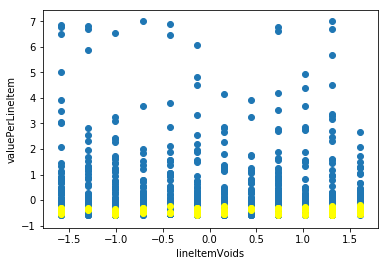

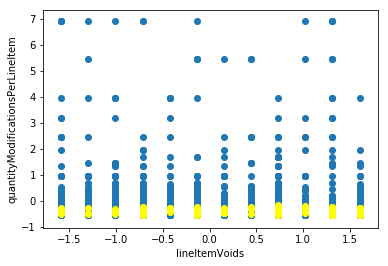

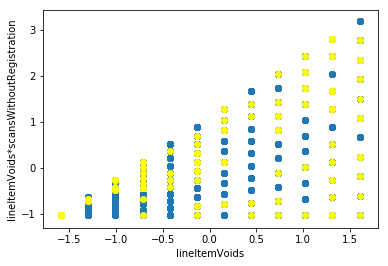

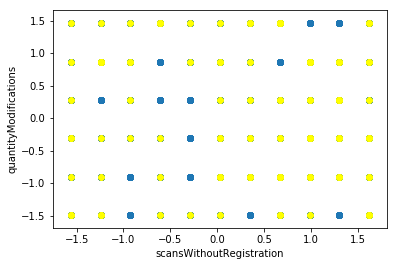

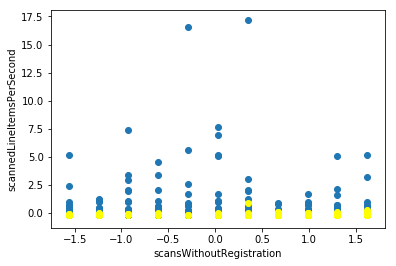

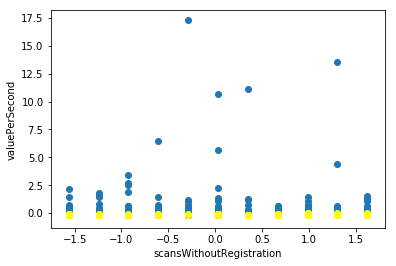

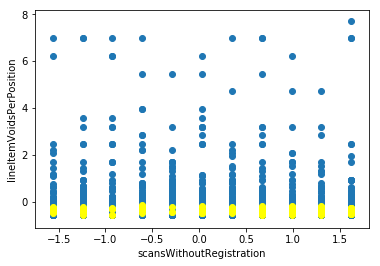

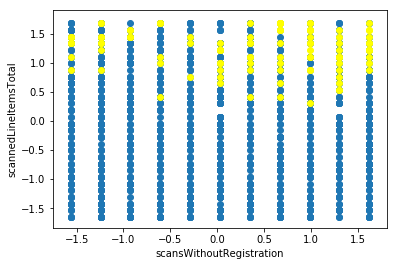

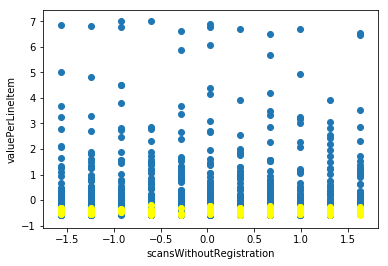

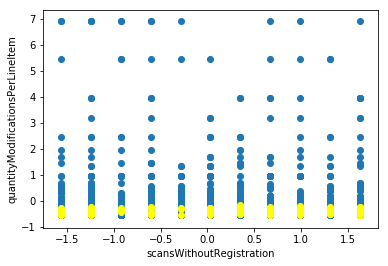

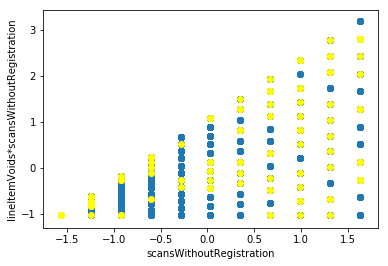

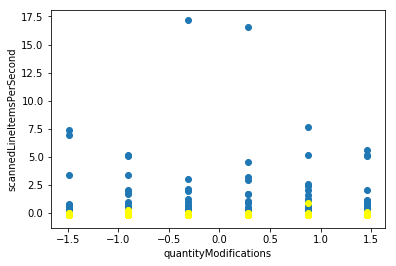

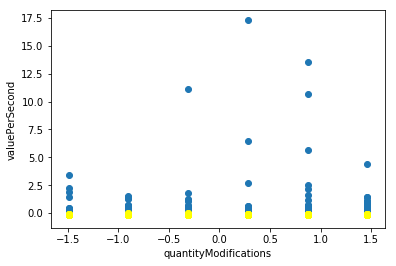

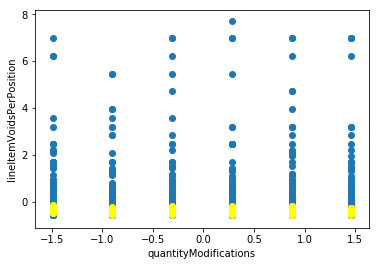

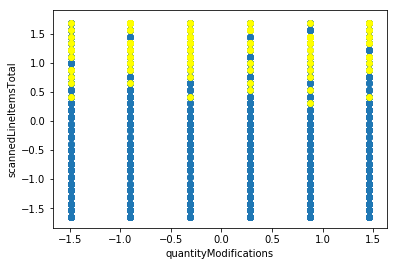

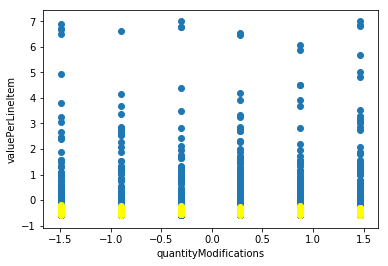

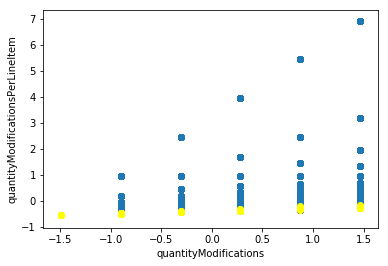

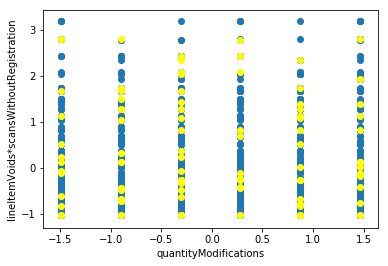

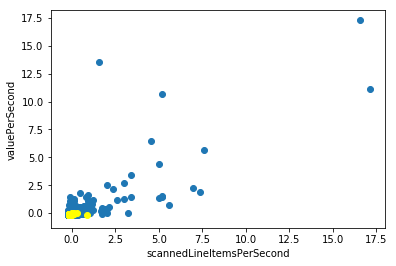

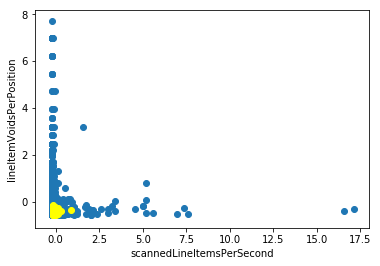

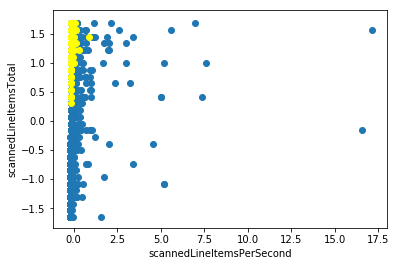

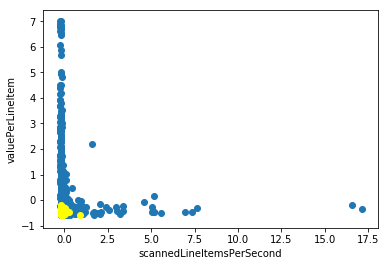

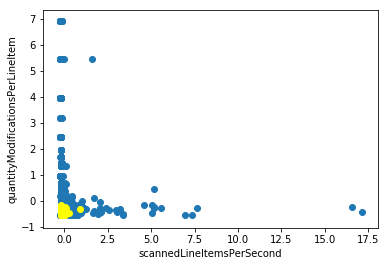

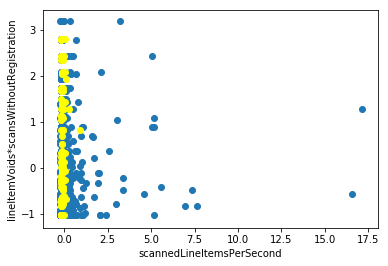

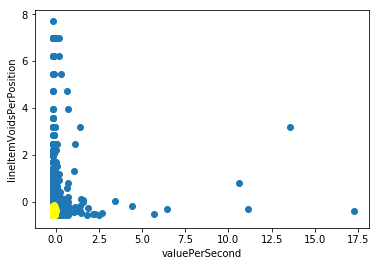

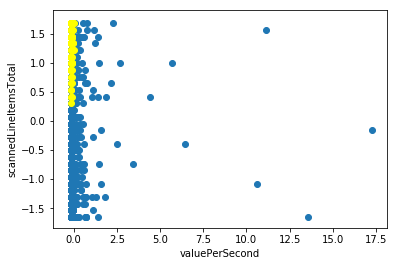

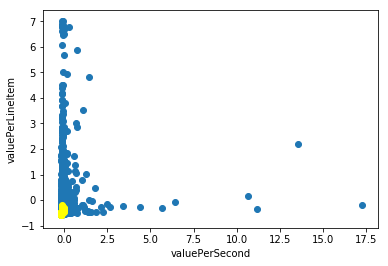

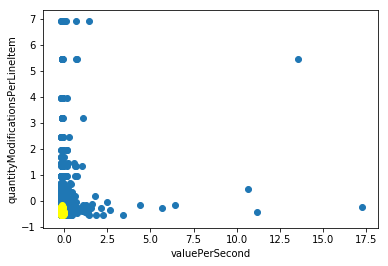

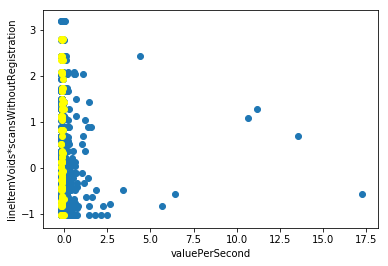

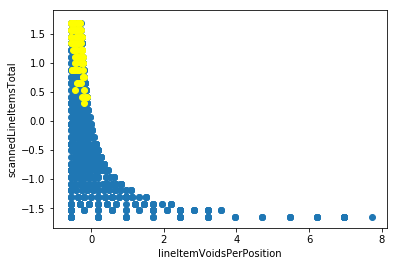

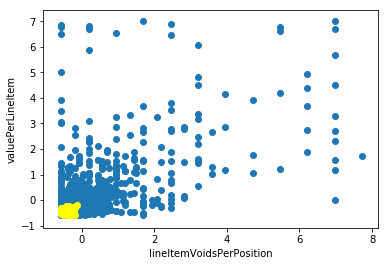

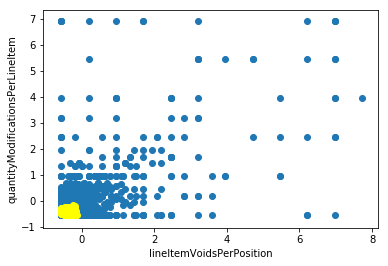

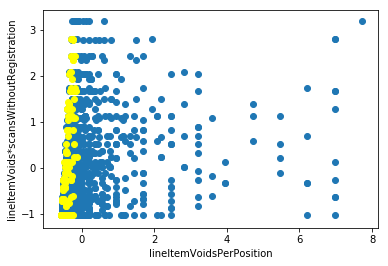

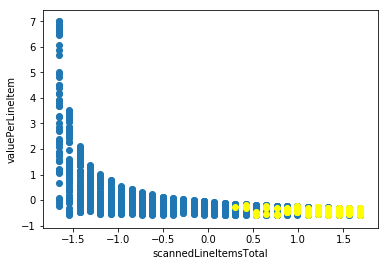

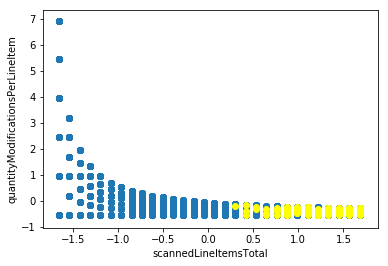

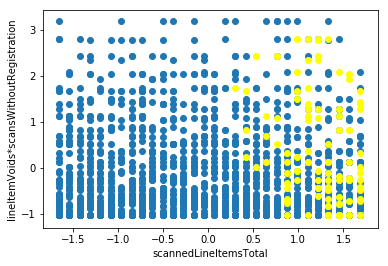

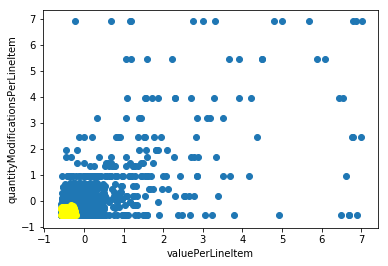

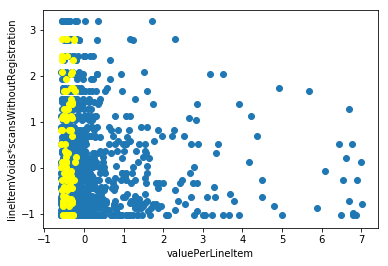

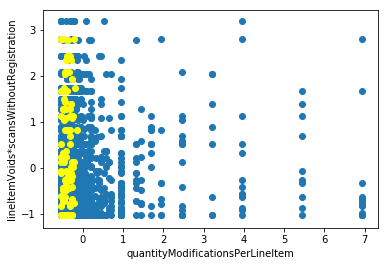

In [45]:
y = train.pop('fraud')
pairs = list(itertools.combinations(train.columns,2))

train['fraud'] = y
for pair in pairs:
    train_0 = train[train['fraud']==0]
    train_1 = train[train['fraud']==1]
    plt.scatter(train_0[pair[0]], train_0[pair[1]])
    plt.xlabel(pair[0])
    plt.ylabel(pair[1])
    plt.scatter(train_1[pair[0]], train_1[pair[1]], color='yellow')
    plt.show()


# Outliers in the fraud=1 class

Selected plots that show outliers in the data. We zoom in a little to see outlier more clearly.

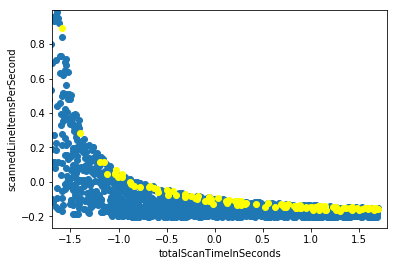

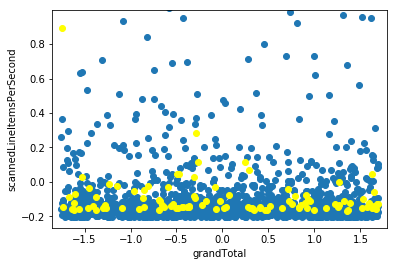

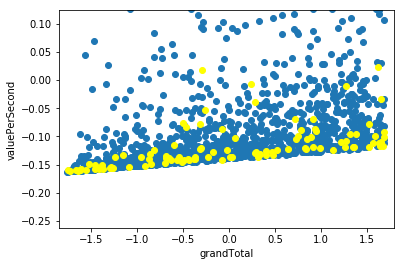

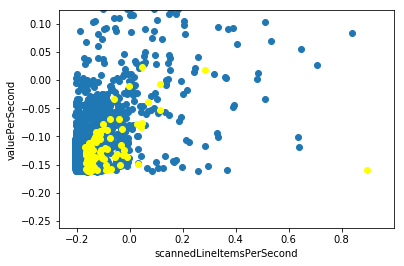

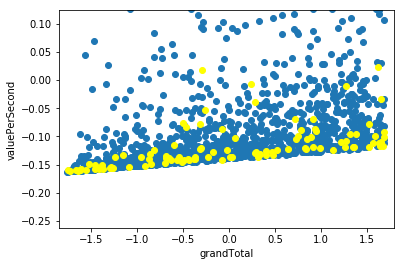

In [46]:
#interesting plots
pairs=[#('trustLevel', 'scannedLineItemsPerSecond'),
        #('trustLevel', 'scannedLineItemsTotal'),
        #('trustLevel', 'valuePerLineItem'),
        #('trustLevel', 'quantityModificationsPerLineItem'),
        ('totalScanTimeInSeconds', 'scannedLineItemsPerSecond'),
        #('totalScanTimeInSeconds', 'scannedLineItemsTotal'),
        #('totalScanTimeInSeconds', 'valuePerLineItem'),
        ('grandTotal', 'scannedLineItemsPerSecond'),
        ('grandTotal', 'valuePerSecond'),
        #('grandTotal', 'lineItemVoidsPerPosition'),
        #('grandTotal', 'scannedLineItemsTotal'),
        #('grandTotal', 'valuePerLineItem'),
        #('grandTotal', 'quantityModificationsPerLineItem'),
        #('lineItemVoids', 'scannedLineItemsPerSecond'),
        #('lineItemVoids', 'valuePerSecond'),
        #('lineItemVoids', 'scannedLineItemsTotal'),
        #('lineItemVoids', 'quantityModificationsPerLineItem'),
        #('scansWithoutRegistration', 'scannedLineItemsPerSecond'),
        #('scansWithoutRegistration', 'lineItemVoidsPerPosition'),
        #('scansWithoutRegistration', 'quantityModificationsPerLineItem'),
        #('quantityModifications', 'scannedLineItemsTotal'),
        ('scannedLineItemsPerSecond', 'valuePerSecond'),
        #('scannedLineItemsPerSecond', 'scannedLineItemsTotal'),
        #('scannedLineItemsPerSecond', 'valuePerLineItem'),
        #('valuePerLineItem', 'quantityModificationsPerLineItem')]
        ('grandTotal', 'valuePerSecond')]
    

for pair in pairs:
    train_0 = train[train['fraud']==0]
    train_1 = train[train['fraud']==1]
    
    #use axis scaling of the fraudster instances
    minx = min(train_1[pair[0]])
    maxx = max(train_1[pair[0]])
    
    miny = min(train_1[pair[1]])
    maxy = max(train_1[pair[1]])
    
    
    plt.xlabel(pair[0])
    plt.ylabel(pair[1])
    plt.xlim(minx-0.1,maxx+0.1)
    plt.ylim(miny-0.1,maxy+0.1)
    plt.scatter(train_0[pair[0]], train_0[pair[1]])
    plt.scatter(train_1[pair[0]], train_1[pair[1]], color='yellow')
    plt.show()


y = train.pop('fraud')
lr = LogisticRegression(C=20)

# Simple Model with all  the outliers

In [47]:
lr = LogisticRegression(C=20, solver='lbfgs')

In [48]:
res = cv_preds_and_confusion_matrix(lr,train,y, cvfolds=10)

       #### Confusion Matrix ####
 True negatives: 1478   False Negatives: 5
 False positives: 6   True Positives: 99
 
Estimated Profit: 320


# Remove some outliers by eyeballed threshold

In [51]:
train['fraud'] = y
loose1 = -1*((train['valuePerSecond']>-0.05) & (train['fraud']==1.0)) + 1
loose2 = -1*((train['scannedLineItemsPerSecond']>0.2) & (train['fraud']==1.0)) +1
train = train[loose1.astype('bool')]
train = train[loose2.astype('bool')]


y = train.pop('fraud')
res = cv_preds_and_confusion_matrix(lr, train,y, cvfolds=10)

/home/html/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


       #### Confusion Matrix ####
 True negatives: 1477   False Negatives: 6
 False positives: 7   True Positives: 91
 
Estimated Profit: 250
